In [1]:
# Standard Python modules
import os, sys
import glob
import numpy as np
import pandas as pd
import xarray as xr

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from matplotlib.projections import get_projection_class

sys.path.append('../modules')
from timeseries import select_months

In [2]:
path_to_data = '/expanse/nfs/cw3e/cwp140/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
## read unique landslide dates
df = pd.read_csv(path_to_out + 'landslide_dates.csv')

IVT_lst = []
Z0_lst = []
UV_lst = []
AR_index_lst = []

for index, row in df.iterrows():
    ## read csv files from landslide dates
    fdate = row['init_date']
    impact_date = row['impact_date']
    model_name = row['model_name']
    F = row['F']
    fname = '/expanse/nfs/cw3e/cwp140/images_historical/{1}/mclimate_init{0}.csv'.format(fdate, impact_date)
    test = pd.read_csv(fname)
    F_lst = np.arange(6, (len(test)*6)+6, 6)
    test['F'] = F_lst
    
    idx = (test['F'] >= F) & (test['F'] < F+24)
    subset = test.loc[idx]
    
    ## pull the maximum values for each var
    IVT_lst.append(subset['IVT'].max())
    Z0_lst.append(subset['Freezing Level'].max())
    UV_lst.append(subset['UV'].max())
    AR_index_lst.append(subset['AR_index'].max())

In [4]:
df['IVT'] = IVT_lst
df['Z0'] = Z0_lst
df['UV'] = UV_lst
df['AR_index'] = AR_index_lst
df

,impact_date,init_date,model_name,F,IVT,Z0,UV,AR_index
0,20020710,20020709,GEFSv12_reforecast,24,98.0,75.0,98.0,2.0
1,20020710,20020708,GEFSv12_reforecast,48,95.0,75.0,98.0,1.0
2,20020710,20020707,GEFSv12_reforecast,72,94.0,75.0,98.0,1.0
3,20020710,20020706,GEFSv12_reforecast,96,92.0,99.0,94.0,1.0
4,20020710,20020705,GEFSv12_reforecast,120,75.0,0.0,75.0,0.0
...,...,...,...,...,...,...,...,...
674,20211001,20210928,GEFS_archive,72,93.0,0.0,99.0,1.0
675,20211001,20210927,GEFS_archive,96,75.0,0.0,98.0,1.0
676,20211001,20210926,GEFS_archive,120,91.0,0.0,97.0,1.0
677,20211001,20210925,GEFS_archive,144,75.0,0.0,93.0,0.0


In [11]:
ssn = 'all'
# ## read csv
# fname = path_to_out + 'box_whisker_2000-2019.csv'
# df1 = pd.read_csv(fname)

# fname = path_to_out + 'box_whisker_2020-2024.csv'
# df2 = pd.read_csv(fname)

# df = pd.concat([df1, df2])
# df['IVT'] = df['IVT']*100
# df['Z0'] = df['Z0']*100
# df['UV'] = df['UV']*100

df = df.set_index(pd.to_datetime(df['impact_date']))
if ssn == 'DJF':
    df = select_months(df, 12, 2)
elif ssn == 'cool-season':
    df = select_months(df, 9, 2)
else:
    df = df
df
df = df.reset_index(drop=True)

In [12]:
idx = (df.F == 48)
tmp = df.loc[idx]
tmp.Z0.describe()

count    97.000000
mean     61.680412
std      40.379075
min       0.000000
25%       0.000000
50%      75.000000
75%      94.000000
max      99.000000
Name: Z0, dtype: float64

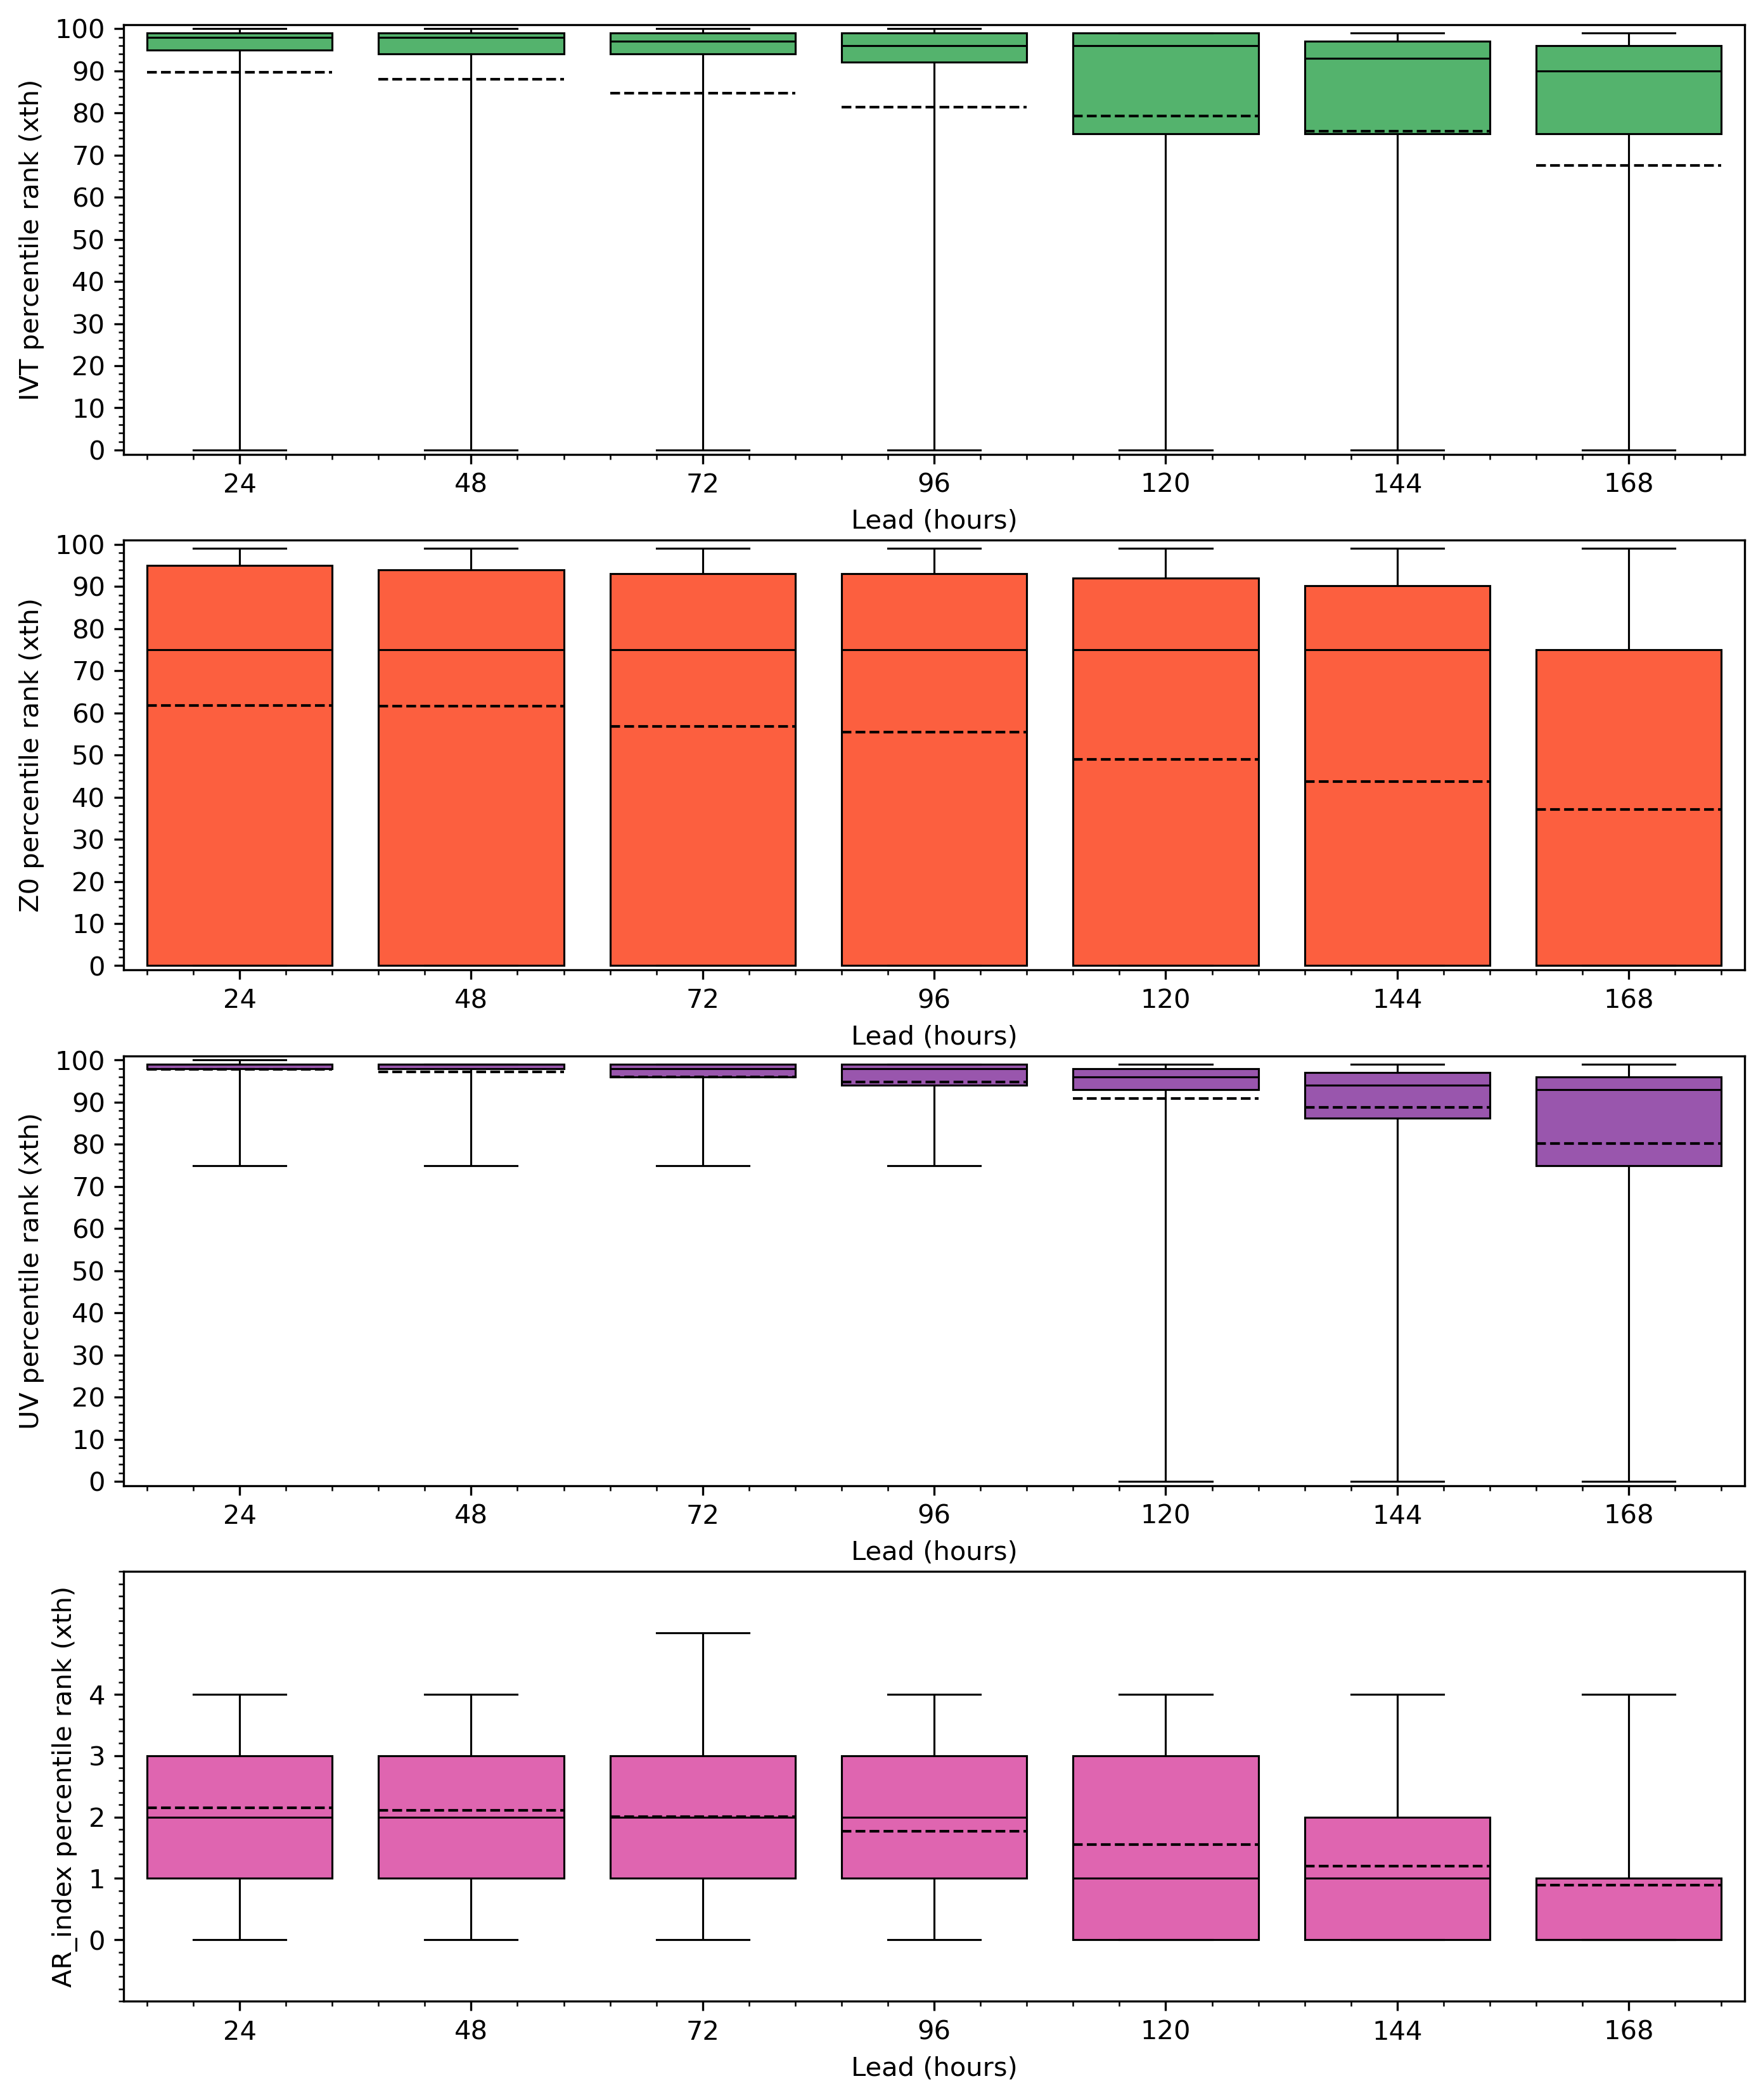

In [13]:
# Create figure
fig = plt.figure(figsize=(11, 13.5))
fig.dpi = 300
fname = path_to_figs + 'box_whisker_{0}'.format(ssn)
fmt = 'png'

nrows = 4
ncols = 1

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1, 1, 1], width_ratios = [1], wspace=0.2, hspace=0.2)
## use gs[rows index, columns index] to access grids

#######################
### BOX AND WHISKER ###
#######################
varname_lst = ['IVT', 'Z0', 'UV', 'AR_index']
color_lst = ['#54B36D', '#FC5F3F', '#9956AD', '#DF65B0']
for i, varname in enumerate(varname_lst):
    ax = fig.add_subplot(gs[i, 0])
    PROPS = {'boxprops':{'facecolor':color_lst[i], 'edgecolor':'k'},
             'medianprops':{"color": "k"},
             'whiskerprops':{"color": "k"},
             'capprops':{"color": "k"},
             'flierprops':{"marker": "x"},
             'meanprops':{'c':'k', 'lw':1},
             'bootstrap': 5000}
    
    bplot = sns.boxplot(y=varname, x="F", data=df, 
                        whis=[0, 100],
                    order=np.arange(24, 8*24, 24),
                    meanline=True, showmeans=True, 
                    notch=False, showcaps=True,
                    linewidth=0.75,
                    **PROPS)
    
    #  set the ticks first
    if varname == 'AR_index':
        plt.ylim(-1., 6)
        bplot.set_yticks(np.arange(0., 5, 1))
    else:
        plt.ylim(-1., 101)
        bplot.set_yticks(np.arange(0., 101, 10))
    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor', bottom=True)
    ax.tick_params(axis='y', which='major')
    
        
    # ax.set_title('(a)', loc='left')
    # ax.annotate(plt_lbl[i], (5, 207), xycoords='axes points', fontsize=12.,
    #         backgroundcolor='white', zorder=100)
    
    ax.set_ylabel('{0} percentile rank (xth)'.format(varname))
    ax.set_xlabel('Lead (hours)')


fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()

In [14]:
# Thus, if we have this weird "flipped" appearance in the notched box plots,
# it simply means that the 1st quartile has a lower value than the confidence of the mean and 
# vice versa for the 3rd quartile. 
# Although it looks ugly, it's actually useful information about the (un)confidence of the median.

In [15]:
def calc_fraction_percentiles(df, varname, F, perc_rank):
    idx = df['F'] == F
    denom = len(df.loc[idx]) # how many impact dates with lead time
    
    idx = (df[varname] == perc_rank) & (df['F'] == F)
    numer = len(df.loc[idx]) # how many impact dates with lead time that have the percentile rank value
    
    return (numer/denom)*100
data_lst = []
varlst = ['IVT', 'Z0', 'UV', 'AR_index']
for i, varname in enumerate(varlst):
    if varname == 'AR_index':
        perc_rank_lst = [0, 1, 2, 3, 4, 5]
    else:
        perc_rank_lst = [0., 75., 90., 94., 95., 96., 97., 98., 99., 100.]

    F_lst = np.arange(24, 168+24, 24)
    for j, perc_rank in enumerate(perc_rank_lst):
        for k, F in enumerate(F_lst):
            frac = calc_fraction_percentiles(df, varname, F, perc_rank)
            data = (varname, perc_rank, F, frac)
            data_lst.append(data)

# create DataFrame using data
df2 = pd.DataFrame(data_lst, columns =['Variable', 'Percentile Rank', 'F', 'Fraction'])
df2

,Variable,Percentile Rank,F,Fraction
0,IVT,0.0,24,6.185567
1,IVT,0.0,48,8.247423
2,IVT,0.0,72,11.340206
3,IVT,0.0,96,14.432990
4,IVT,0.0,120,14.432990
...,...,...,...,...
247,AR_index,5.0,72,1.030928
248,AR_index,5.0,96,0.000000
249,AR_index,5.0,120,0.000000
250,AR_index,5.0,144,0.000000


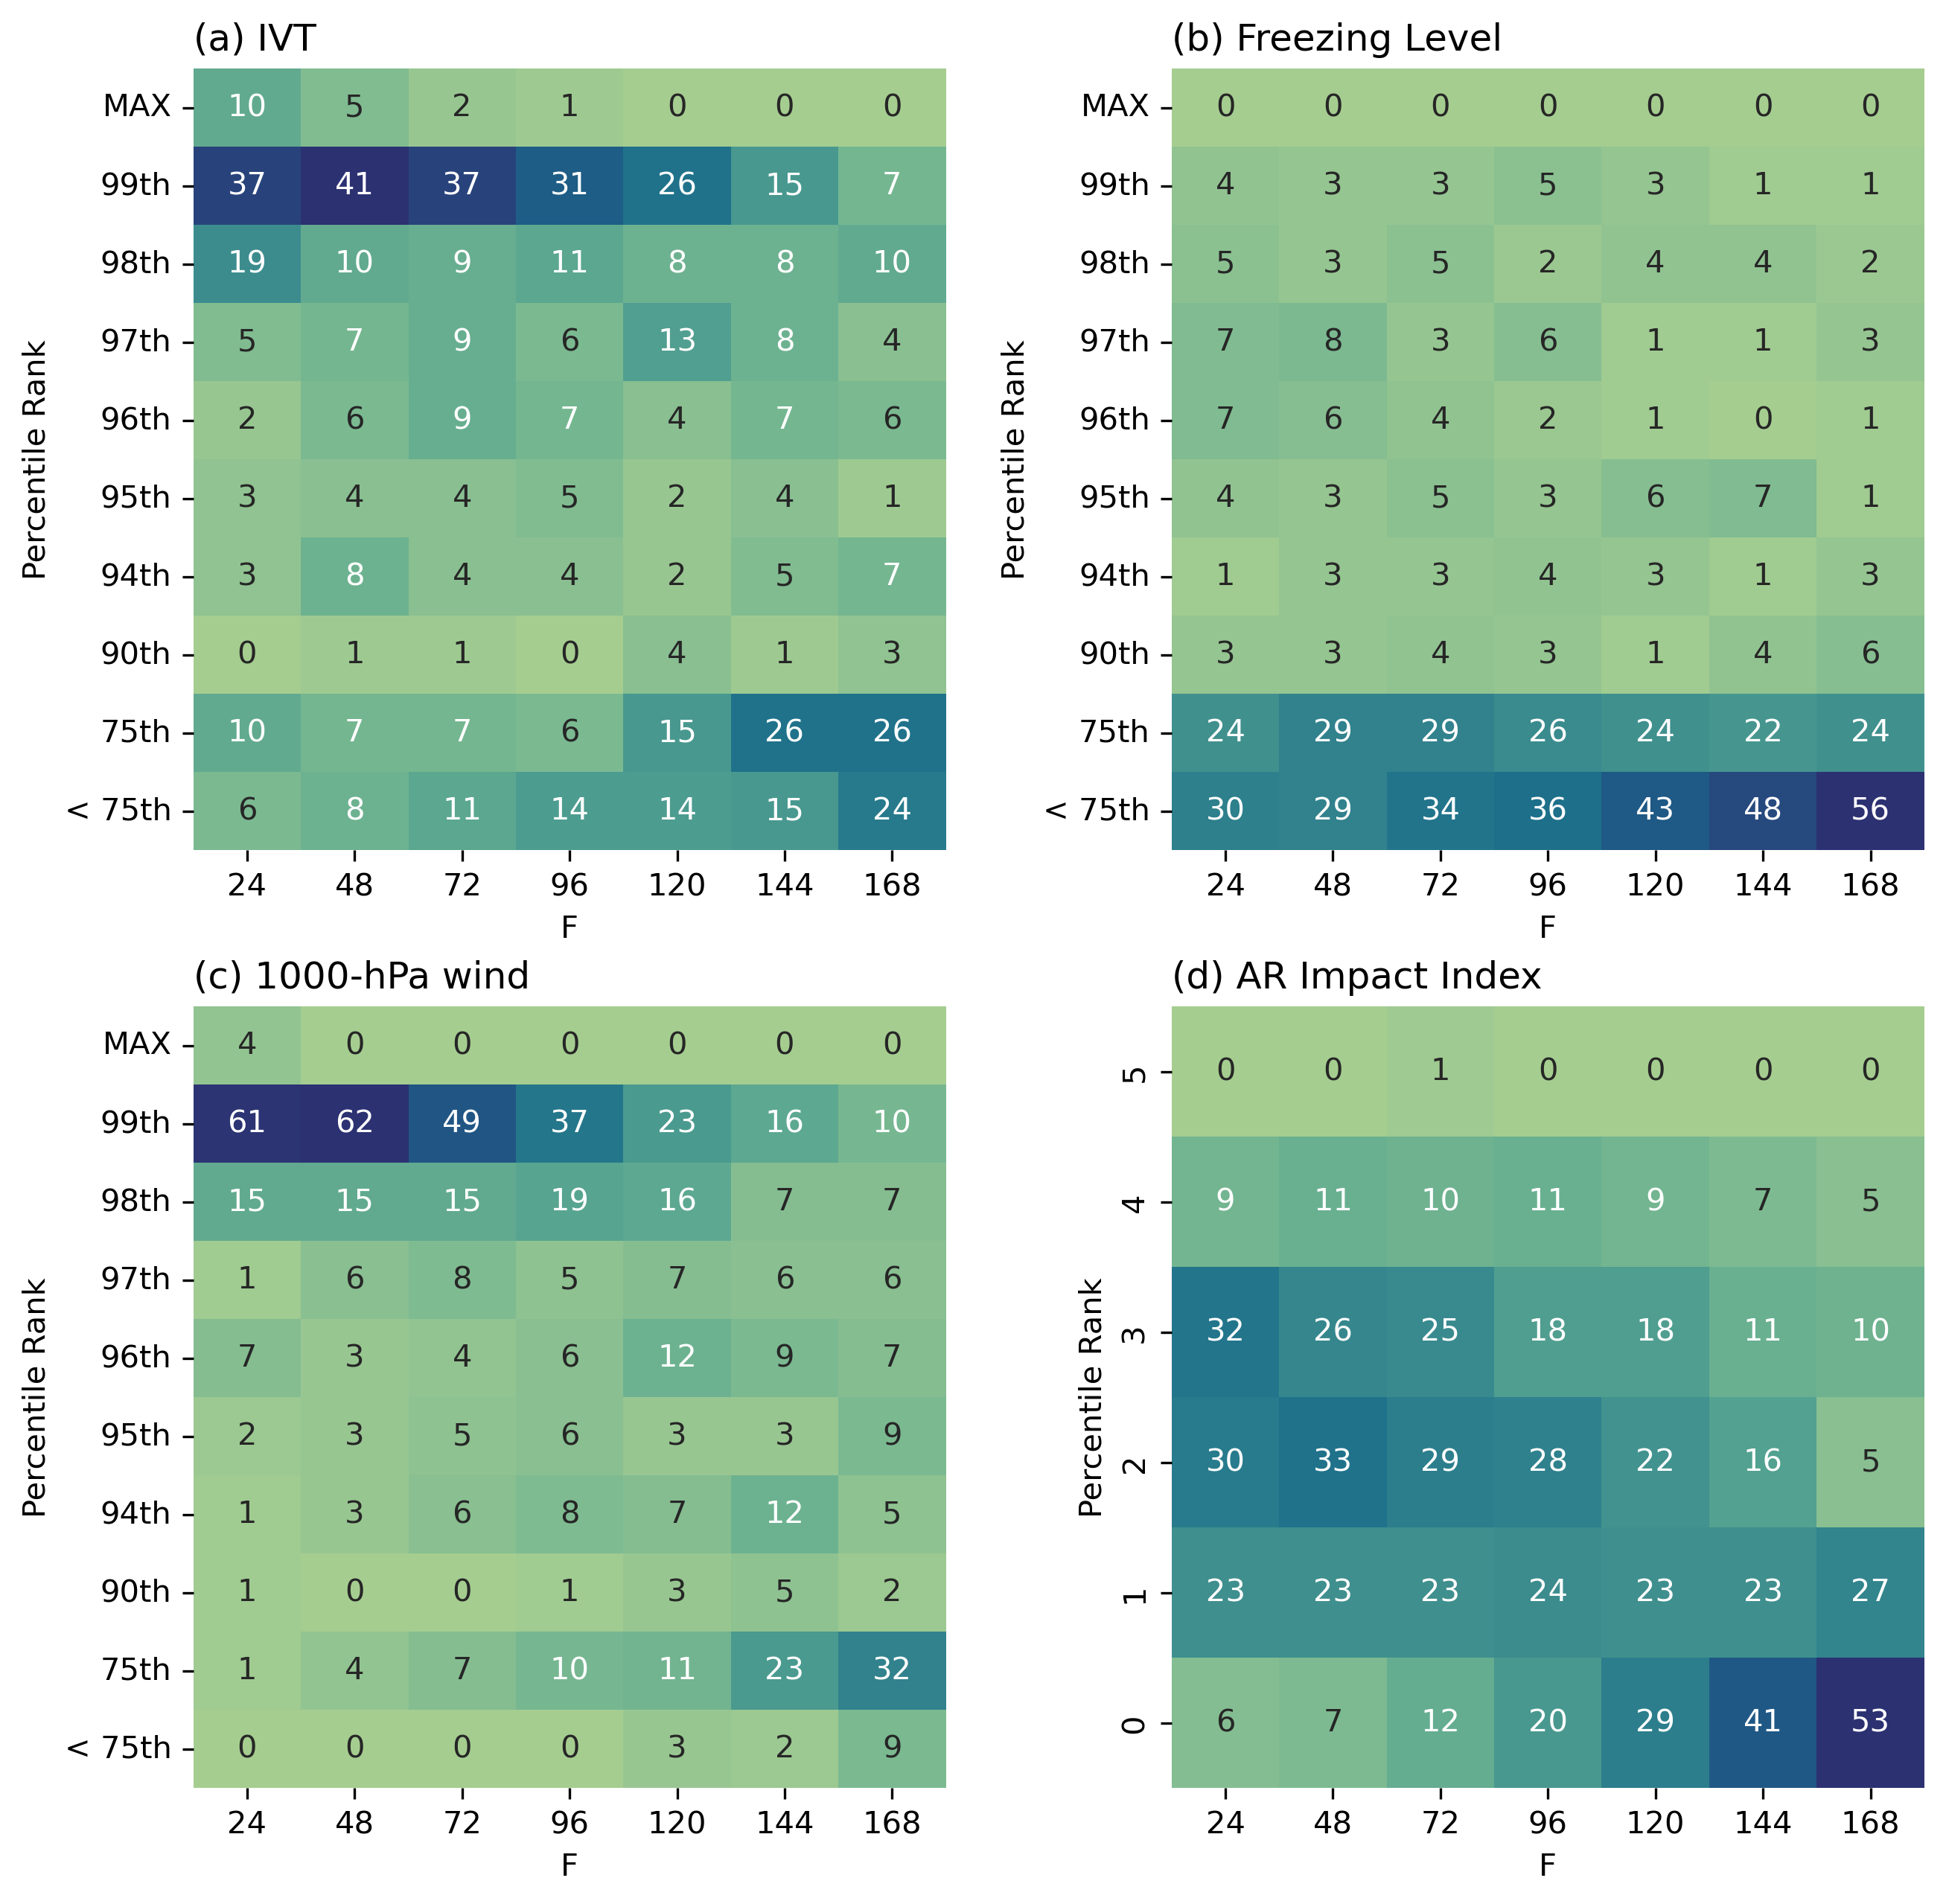

In [16]:
# Create figure
fig = plt.figure(figsize=(10, 10))
fig.dpi = 300
fname = path_to_figs + 'heatmaps_{0}'.format(ssn)
fmt = 'png'

nrows = 2
ncols = 2

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1, 1], width_ratios = [1, 1], wspace=0.3, hspace=0.2)
## use gs[rows index, columns index] to access grids

#######################
### BOX AND WHISKER ###
#######################
varname_lst = ['IVT', 'Z0', 'UV', 'AR_index']
title_lst = ['(a) IVT', '(b) Freezing Level', '(c) 1000-hPa wind', '(d) AR Impact Index']
row_idx = [0, 0, 1, 1]
col_idx = [0, 1, 0, 1]
for i, varname in enumerate(varname_lst):
    ax = fig.add_subplot(gs[row_idx[i], col_idx[i]])

    tmp = df2.loc[df2['Variable'] == varname].pivot(index="Percentile Rank", columns="F", values="Fraction")
    if varname == 'AR_index':
        tck_lbly = [0, 1, 2, 3, 4, 5]
    else:
        tck_lbly = ['< 75th', '75th', '90th', '94th', '95th', '96th', '97th', '98th', '99th', 'MAX']
    g = sns.heatmap(tmp, annot=True, fmt=".0f", cmap="crest", cbar=False, yticklabels=tck_lbly, ax=ax)
    g.invert_yaxis()

    ax.set_title(title_lst[i], loc='left')

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)

# Show
plt.show()